## 1. Data source: PAMAP2 (UCI)

**Dataset:** *PAMAP2 Physical Activity Monitoring* (UCI Machine Learning Repository)

- **UCI dataset page (download + description):** https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring  
- **Local path (expected):** download and unzip the dataset into `./data/pamap2/` (the `data/` directory is not committed to git)  
- **Dataset readme (format / notes):** https://archive.ics.uci.edu/ml/machine-learning-databases/00231/readme.pdf  
- **License:** Creative Commons Attribution 4.0 International (**CC BY 4.0**)

PAMAP2 is a public wearable-sensing dataset for **human activity recognition (HAR)**. It contains recordings from **9 subjects** performing **18 labeled activities** (plus label `0` for transient/other) while wearing three IMU sensors (**hand/wrist**, **chest**, **ankle**) and a heart-rate monitor.

**File format (from the dataset readme):** each row has **54 columns**:
- `1` timestamp (s)
- `2` activityID
- `3` heart rate (bpm)
- `4–20` IMU hand (wrist)
- `21–37` IMU chest
- `38–54` IMU ankle

Each IMU block contains:
- temperature (°C)
- 3D accelerometer (±16g) and 3D accelerometer (±6g)
- 3D gyroscope (rad/s)
- 3D magnetometer (μT)
- orientation (not valid in this collection)

**Activity IDs (18 activities + transient):**
1 lying; 2 sitting; 3 standing; 4 walking; 5 running; 6 cycling; 7 Nordic walking;  
9 watching TV; 10 computer work; 11 car driving; 12 ascending stairs; 13 descending stairs;  
16 vacuum cleaning; 17 ironing; 18 folding laundry; 19 house cleaning; 20 playing soccer; 24 rope jumping;  
0 other (transient activities)

**What we use in this notebook:** **Protocol** recordings only, with a **watch-like setup**: wrist IMU signals (ACC/GYRO/MAG) as inputs and the **activityID** as the multi-class label. We **exclude label `0`** (“transient/other”) to keep the benchmark focused on the defined activities.


## 2. Load data & quick sanity checks

We load the **Protocol** recordings (one file per subject) from `./data/pamap2/`. The raw `.dat` files do not include column headers, so we explicitly assign the **54 columns** defined in the dataset readme. A `subject_id` is added based on the filename.

As a sanity check, we verify that the raw files match the expected **54-column** structure. After this check passes, we immediately **subset to the wrist/hand signals** plus the minimal metadata needed for HAR (`timestamp_s`, `activity_id`, `subject_id`). We also **drop the orientation channels** because they are stated to be **invalid** in this data collection.

Finally, we summarize **activity coverage per subject** and visualize **subject-wise missingness** for the wrist channels.


In [1]:
from pathlib import Path
import re

import numpy as np
import pandas as pd

# --- Paths ---
DATA_ROOT = Path("../data/pamap2")
PROTOCOL_DIR = DATA_ROOT / "PAMAP2_Dataset" / "Protocol"

# --- Column names (54 total, per PAMAP2 readme structure) ---
# 1 timestamp, 1 activity_id, 1 heart_rate, then 3x IMU blocks (hand/chest/ankle), 17 cols each.
IMU_COLS = [
    "temp_c",
    "acc16_x", "acc16_y", "acc16_z",
    "acc6_x",  "acc6_y",  "acc6_z",
    "gyro_x",  "gyro_y",  "gyro_z",
    "mag_x",   "mag_y",   "mag_z",
    "ori_w",   "ori_x",   "ori_y",   "ori_z",
]

COLS = (
    ["timestamp_s", "activity_id", "heart_rate_bpm"]
    + [f"hand_{c}" for c in IMU_COLS]
    + [f"chest_{c}" for c in IMU_COLS]
    + [f"ankle_{c}" for c in IMU_COLS]
)
assert len(COLS) == 54, f"Expected 54 columns, got {len(COLS)}"

# A small "column map" pattern
COLUMN_MAP = {
    "timestamp_s": "timestamp_s",
    "activity_id": "activity_id",
    "heart_rate_bpm": "heart_rate_bpm",
    # wrist/hand IMU blocks:
    **{f"hand_{c}": f"hand_{c}" for c in IMU_COLS},
}

def _parse_subject_id(path: Path) -> int:
    m = re.search(r"subject(\d+)\.dat$", path.name)
    if not m:
        raise ValueError(f"Could not parse subject id from filename: {path.name}")
    return int(m.group(1))

def load_subject_file(path: Path) -> pd.DataFrame:
    df = pd.read_csv(
        path,
        sep=r"\s+",
        header=None,
        names=COLS,
        na_values=["NaN"],
        engine="python",
    )
    df.insert(0, "subject_id", _parse_subject_id(path))
    return df

# --- Load all Protocol subject files ---
subject_files = sorted(PROTOCOL_DIR.glob("subject*.dat"))
if not subject_files:
    raise FileNotFoundError(
        f"No subject*.dat files found under: {PROTOCOL_DIR}\n"
        f"Check that you unzipped PAMAP2 into: {DATA_ROOT}"
    )

dfs = [load_subject_file(p) for p in subject_files]
data = pd.concat(dfs, ignore_index=True)

# --- Quick sanity checks ---
print(f"Raw files OK: {data.shape[1] - 1} raw columns (expected 54)")

Raw files OK: 54 raw columns (expected 54)


,n_samples,n_activities (of 19 incl. 0: transient)
subject_id,,
101,376417,13
102,447000,13
103,252833,9
104,329576,12
105,374783,13
106,361817,13
107,313599,12
108,408031,13
109,8477,2


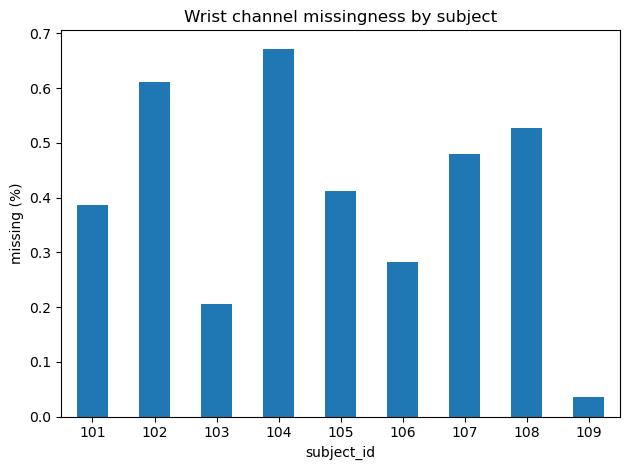

In [2]:
import matplotlib.pyplot as plt

# --- Subset to wrist/hand only + drop invalid orientation channels ---
hand_keep = [
    # temperature
    "hand_temp_c",
    # acc (±16g)
    "hand_acc16_x", "hand_acc16_y", "hand_acc16_z",
    # acc (±6g)
    "hand_acc6_x",  "hand_acc6_y",  "hand_acc6_z",
    # gyro
    "hand_gyro_x",  "hand_gyro_y",  "hand_gyro_z",
    # mag
    "hand_mag_x",   "hand_mag_y",   "hand_mag_z",
    # orientation is intentionally dropped: hand_ori_w/x/y/z (invalid in this dataset)
]
data = data[["subject_id", "timestamp_s", "activity_id"] + hand_keep]
# --- Activity coverage per subject---
activity_coverage = (
    data.groupby("subject_id")["activity_id"]
        .agg(n_samples="count", n_activities="nunique")
        .rename(columns={"n_activities": "n_activities (of 19 incl. 0: transient)"})
)
display(activity_coverage)

# --- Subject-wise missingness (wrist channels) ---
wrist_cols = hand_keep
subject_missing_pct = (
    data.groupby("subject_id")[wrist_cols]
        .apply(lambda df: df.isna().mean().mean() * 100)  # avg missing % across wrist channels
        .rename("missing_%")
        .sort_index()
)

ax = subject_missing_pct.plot(kind="bar", rot=0)
ax.set_xlabel("subject_id")
ax.set_ylabel("missing (%)")
ax.set_title("Wrist channel missingness by subject")
plt.tight_layout()
plt.show()

## 3. Preprocessing

In this section, we prepare the wrist IMU signals for windowing and feature extraction:

- We **remove transient activity samples** (`activity_id == 0`) to focus on well-defined activity classes.
- We handle **missing values** by interpolating short gaps **within each subject** and dropping any remaining missing samples.
- For each tri-axial wrist sensor, we compute the **vector magnitude** signal to provide an orientation-robust representation.

We visualize as an example, the **vector magnitude signals computed** for a short segment of one subject and one activity.


In [3]:
# 1) Drop transient activity (activity_id == 0)
data = data[data["activity_id"] != 0].copy()

# 2) Handle missing values: interpolate within each subject, then drop remaining NaNs
# Columns to interpolate (wrist signals only; keep metadata untouched)
INTERP_COLS = hand_keep  # from Section 2 (wrist channels we kept)

data = data.sort_values(["subject_id", "timestamp_s"]).copy()

# Interpolate within each subject for the wrist channels
data[INTERP_COLS] = (
    data.groupby("subject_id")[INTERP_COLS]
        .transform(lambda s: s.interpolate(method="linear", limit_direction="both"))
)

# Drop any remaining missing samples
data = data.dropna()

# 3) Compute vector magnitude signals for tri-axial wrist sensors
def vector_magnitude(df, cols, name):
    df[name] = np.sqrt((df[cols] ** 2).sum(axis=1))
    return df

data = vector_magnitude(
    data,
    ["hand_acc16_x", "hand_acc16_y", "hand_acc16_z"],
    "hand_acc16_mag",
)
data = vector_magnitude(
    data,
    ["hand_acc6_x", "hand_acc6_y", "hand_acc6_z"],
    "hand_acc6_mag",
)
data = vector_magnitude(
    data,
    ["hand_gyro_x", "hand_gyro_y", "hand_gyro_z"],
    "hand_gyro_mag",
)
data = vector_magnitude(
    data,
    ["hand_mag_x", "hand_mag_y", "hand_mag_z"],
    "hand_mag_mag",
)

print("Preprocessed data shape:", data.shape)


Preprocessed data shape: (1942872, 20)


In [4]:
ACTIVITY_MAP = {
    1: "lying",
    2: "sitting",
    3: "standing",
    4: "walking",
    5: "running",
    6: "cycling",
    7: "Nordic walking",
    9: "watching TV",
    10: "computer work",
    11: "car driving",
    12: "ascending stairs",
    13: "descending stairs",
    16: "vacuum cleaning",
    17: "ironing",
    18: "folding laundry",
    19: "house cleaning",
    20: "playing soccer",
    24: "rope jumping",
}

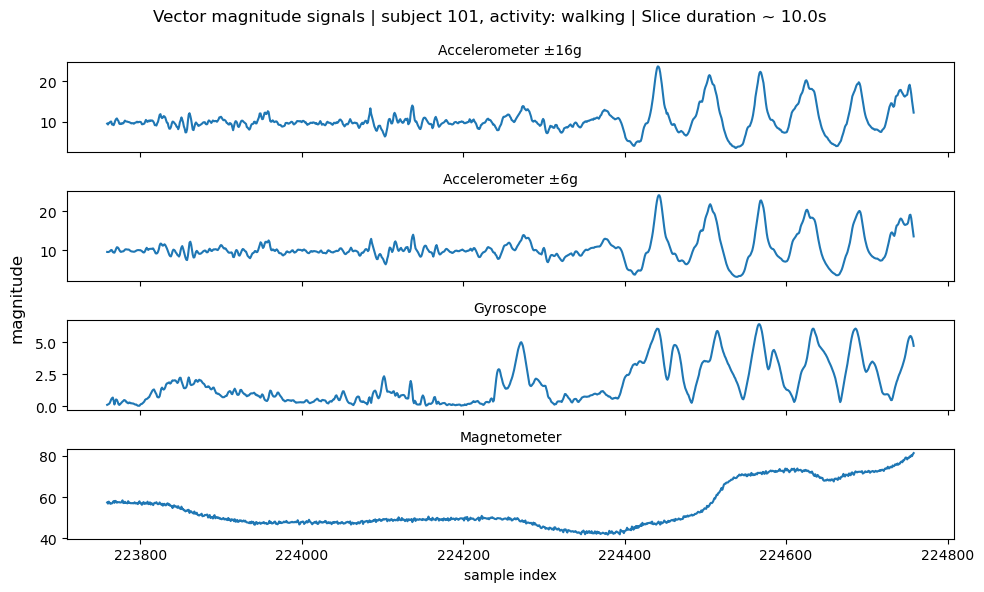

In [15]:
# --- Example Visualization (one subject, one activity) ---

# Selecting an example subject and activity
example_subject = 101 # subject_id: 101-109
example_activity = 4  # choose from ACTIVITY_MAP keys (e.g., 4 = walking)

example = data[
    (data["subject_id"] == example_subject) &
    (data["activity_id"] == example_activity)
]

if example.empty:
    raise ValueError(
        f"Activity {example_activity} ({ACTIVITY_MAP.get(example_activity, 'unknown')}) "
        f"not found for subject {example_subject}"
    )

example = example.iloc[:1000]

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True, sharey=False)

signals = [
    ("hand_acc16_mag", "Accelerometer ±16g"),
    ("hand_acc6_mag",  "Accelerometer ±6g"),
    ("hand_gyro_mag",  "Gyroscope"),
    ("hand_mag_mag",   "Magnetometer"),
]

for ax, (col, subtitle) in zip(axes, signals):
    ax.plot(example[col])
    ax.set_title(subtitle, fontsize=10)
    ax.set_ylabel("")

activity_name = ACTIVITY_MAP.get(example_activity, str(example_activity))
axes[-1].set_xlabel("sample index")
duration_s = float(example["timestamp_s"].iloc[-1] - example["timestamp_s"].iloc[0])
fig.suptitle(
    f"Vector magnitude signals | subject {example_subject}, activity: {activity_name} | Slice duration ~ {duration_s:.1f}s",
    y=0.98,
)

# one shared y-label
fig.supylabel("magnitude")

plt.tight_layout()
plt.show()


## 4. Windowing

We segment the continuous wrist IMU signals into **fixed-length sliding windows**, which are the basic samples used for feature extraction and modeling in wearable activity recognition.

We use a **5-second window** with **50% overlap**, a common and widely accepted choice in HAR that balances temporal context with responsiveness. Windowing is performed **within each subject** to preserve temporal structure and avoid leakage. The effective **sampling rate is estimated from timestamps** to translate time-based window definitions (seconds) into sample indices in a data-driven way.

Each window is assigned a single activity label using a **majority vote** over the samples it contains. To reduce label noise near activity transitions, we apply a **label purity threshold of 0.8** (a common choice in HAR) and **discard windows below this threshold**, focusing the model on learning from **steady-state activities** rather than ambiguous transition regions.
